# Thực hành về nhà: Mô hình sinh DCGAN

In [22]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

/bin/bash: line 1: nvidia-smi: command not found
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
width = 28
height = 28
channels = 1

<H2>1. Load dữ liệu MNIST</H2>


In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

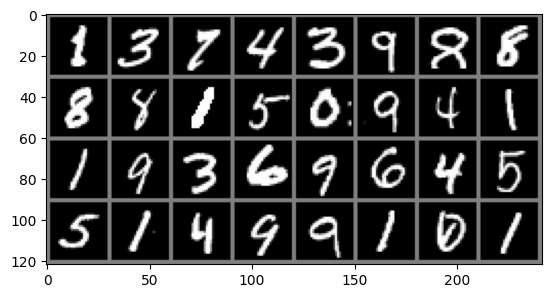

    1     3     7     4     3     9     8     8     8     8     1     5     0     9     4     1     1     9     3     6     9     6     4     5     5     1     4     9     9     1     0     1


In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>

Lập trình mạng generator.
    
    + Đầu vào là vector ngẫu nhiên 100 chiều.
    + Đầu ra là một ảnh fake với giá trị pixel trong khoảng [-1, 1].

Các thông số của mạng như sau

- Dense(7*7*128, kernel_initializer='glorot_normal',input_shape=(inidim,)))
- LeakyReLU(0.2))
- Reshape( [7, 7, 128])
- UpSampling2D(size=(2, 2))
- Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')
- LeakyReLU(0.2)
- UpSampling2D(size=(2, 2))
- Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform'))
- Activation('tanh')



In [26]:
class Generator(nn.Module):
    ##########################
    ###   YOUR CODE HERE   ###
    ##########################
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100, 6272)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.reshape = lambda x: x.view(-1, 128, 7, 7)
        self.upsampling = nn.Upsample(scale_factor = (2,2))
        self.conv1 = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=5, padding=2)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.fc(x)
        x = self.leaky_relu(x)
        x = self.reshape(x)
        x = self.upsampling(x)
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.upsampling(x)
        x = self.conv2(x)
        x = self.act(x)
        return x



G = Generator()
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
         LeakyReLU-2                 [-1, 6272]               0
          Upsample-3          [-1, 128, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]         204,864
         LeakyReLU-5           [-1, 64, 14, 14]               0
          Upsample-6           [-1, 64, 28, 28]               0
            Conv2d-7            [-1, 1, 28, 28]           1,601
              Tanh-8            [-1, 1, 28, 28]               0
Total params: 839,937
Trainable params: 839,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.87
Params size (MB): 3.20
Estimated Total Size (MB): 4.08
----------------------------------------------------------------
_____________________ Generator Created___

<H2>4. Discriminator</H2>

Khai báo mạng discriminator

    + Đầu vào là một ảnh 28x28
    + Đầu ra là một xác suất cho ta biết ảnh đấy là real hay fake với giá trị trong miền [0, 1]

Thông số của mạng như sau:

-  Conv2D(64, (5, 5), strides=(2, 2), padding= 'same',input_shape=shp)
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Flatten()
-  Dense(1,activation='sigmoid')

In [27]:
class Discriminator(nn.Module):
    ##########################
    ###   YOUR CODE HERE   ###
    ##########################
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, padding=2, stride=2, kernel_size=5)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout2d(0.5)
        self.conv2 = nn.Conv2d(64, 128, padding=2, stride=2, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128*7*7,1)
        self.act = nn.Sigmoid()
    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.act(x)
        return x

D = Discriminator()
summary(D, (1, 28, 28), batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
         LeakyReLU-2           [-1, 64, 14, 14]               0
         Dropout2d-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
         LeakyReLU-5            [-1, 128, 7, 7]               0
         Dropout2d-6            [-1, 128, 7, 7]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                    [-1, 1]           6,273
           Sigmoid-9                    [-1, 1]               0
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.81
Estimated Total Size (MB): 1.29
-------------------------------------------

<h2>5. GAN model</h2>

Chúng ta ghép hai mạng vào với nhau mang generator trước, mạng disciminator sau

Lập trình hàm để ghép mạng

In [28]:
##########################
###   YOUR CODE HERE   ###
##########################
from tensorflow.keras.models import Sequential
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters())
optimizer_D = optim.Adam(D.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)
D.to(device)

losses_G = []
losses_D = []
samples = []

In [36]:
for epoch in range(3):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        device = torch.device("cuda" if torch.cuda.is_available else "cpu")
        valid = torch.full((imgs.size(0), 1), 1.0, dtype=torch.float32, device="cpu")
        fake = torch.full((imgs.size(0), 1), 0.0, dtype=torch.float32, device="cpu")

        # Configure input
        real_imgs = imgs.to(device="cpu", dtype=torch.float32)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), 100, device="cpu")

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator

        ##########################
        ###   YOUR CODE HERE   ###
        ##########################
        g_loss = criterion(D(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss measures discriminator's ability to classify real from generated samples

        ##########################
        ###   YOUR CODE HERE   ###
        ##########################
        fake_loss = criterion(D(gen_imgs.detach()), fake) #detach -> tách khoỉ dồ thị -> không cập nhật trọng số của Gen khi tính backward
        valid_loss = criterion(D(real_imgs), valid)
        d_loss = (fake_loss + valid_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if epoch % 2 == 0 and i == 10:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, 3, i, len(trainloader), d_loss.item(), g_loss.item())
            )

            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs.cpu().detach())


[Epoch 0/3] [Batch 10/1875] [D loss: 0.000029] [G loss: 13.739170]


KeyboardInterrupt: 

### Vẽ đồ thị loss khi huấn luyện

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(losses_G)/10)*10), losses_G, label="G_loss")
plt.plot(list(range(len(losses_D)/10)*10), losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

### Trực quan dữ liệu sinh ra thử mạng học được

In [ ]:
i = 0
for i in range(0, len(samples), 10):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")